In [1]:
from src import *
from src.extra import ExEstimates
import matplotlib.ticker as ticker

from src.parallelize import parallelize

In [2]:
width = 8.5 / 2.54

plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath, amssymb, physics}'

formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((0, 0))

plt.rcParams['axes.linewidth']=0.5
spade_params = {
    'marker': 'o',
    'edgecolors': 'tab:blue',
    'facecolors': 'none',
    's': 7,
    'linewidths': 0.5
}

di_params = {
    'marker': '+',
    'facecolor': 'k',
    's': 9,
    'linewidths': 0.5
}


plt.rcParams['xtick.major.size'] = 4.5
plt.rcParams['xtick.minor.size'] = 2.5
plt.rcParams['xtick.major.width'] = 0.5
plt.rcParams['xtick.minor.width'] = 0.5
plt.rcParams['xtick.minor.visible'] = 'True'
plt.rcParams['ytick.major.size'] = 4.5
plt.rcParams['ytick.minor.size'] = 2.5
plt.rcParams['ytick.major.width'] = 0.5
plt.rcParams['ytick.minor.width'] = 0.5
plt.rcParams['ytick.minor.visible'] = 'True'

In [3]:
freq_list = np.linspace(0.1, 0.4, 61)
delay_params = (2.8e-3 + 1e-6, 0.48e-3)

In [4]:
@parallelize()
def run(f, m, a):
    meta = MetaData(m, np.round(f, 5), DMD.A(a) * (4 / pi))
    c = Simulator(meta, 'sin', delay_params).gen()
    c = c.est()
    c.metadata = MetaData(m, np.round(f, 5), DMD.A(a))
    c.savez('TEMP/')
    return c

# _ = [(run(freq_list, 'DI', a), run(freq_list, 'SPADE', a)) for a in (3, 5)]

In [5]:
for j, a in enumerate((3, 5)):
    for m in ('SPADE', 'DI'):
        f_var, f_mean = [], []
        for i, f in enumerate(freq_list):
            meta = MetaData(m, np.round(f, 5), DMD.A(a))
            c = LoadEstimates(f'TEMP/SIN/{meta.convert2str()}.npz')
            f_mean.append(c.estimates.mean())
            f_var.append(c.estimates.var(ddof=1) * c.photons)
        np.savez(rf'result/sim/sin/{meta.convert2str()[:-8]}.npz', mean=np.array(f_mean), var=np.array(f_var))


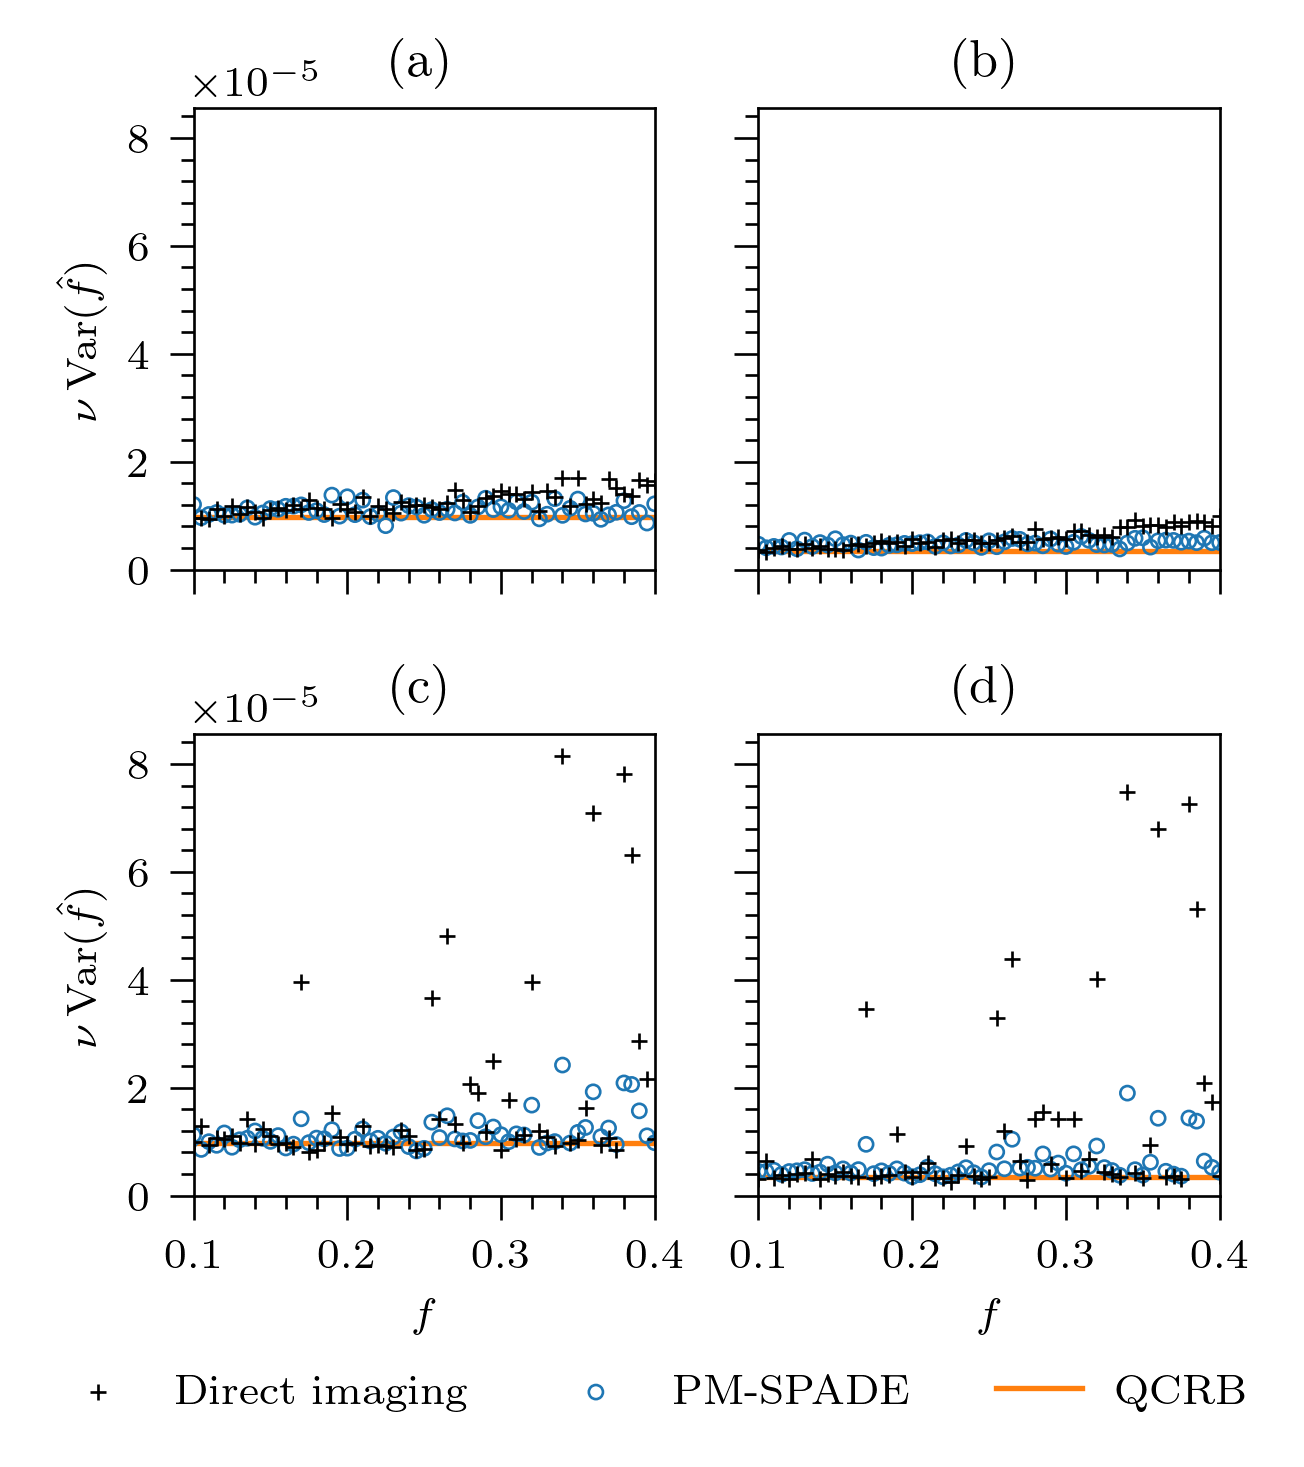

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(width, width*1.1), sharex=True, sharey=True)

for j, a in enumerate((3, 5)):
    fi = DI.ApproxCFI((4 / pi) * DMD.A(a))
    line3 = axes[0, j].axhline(1/fi, color='tab:orange', zorder=1, label='QCRB')
    axes[1, j].axhline(1/fi, color='tab:orange', zorder=1, label='QCRB')

for k, w in enumerate(('SIN', 'SIGN')):
    for j, a in enumerate((3, 5)):
        for m in ('SPADE', 'DI'):
            # f_var, f_mean = [], []
            # for i, f in enumerate(freq_list):
            #     meta = MetaData(m, np.round(f, 5), DMD.A(a))
            #     c = LoadEstimates(f'TEMP/{w}/{meta.convert2str()}.npz')
            #     f_mean.append(c.estimates.mean())
            #     f_var.append(c.estimates.var(ddof=1) * c.photons)
            # np.savez(rf'result/sim/{w.lower()}/{meta.convert2str()[:-8]}.npz', mean=np.array(f_mean), var=np.array(f_var))

            f_var = np.load(rf'result/sim/{w.lower()}/{m.lower()}_{a}px.npz')['var']

            if m.lower() == 'spade':
                line1 = axes[k, j].scatter(freq_list, f_var, **spade_params, label=m)
            elif m.lower() == 'di':
                line2 = axes[k, j].scatter(freq_list, f_var, **di_params, label=m)



# axes[0, 0].set_title(r'$0.28 \sigma \cdot \sin(2\pi f n)$', loc="right")
# axes[0, 1].set_title(r'$0.47 \sigma \cdot \sin(2\pi f n)$', loc="right")
# axes[1, 0].set_title(r'$0.28 \sigma \cdot \operatorname{sgn}\qty[\sin(2\pi f n)]$', loc="right")
# axes[1, 1].set_title(r'$0.47 \sigma \cdot \operatorname{sgn}\qty[\sin(2\pi f n)]$', loc="right")

axes[0, 0].set_title(r'(a)')
axes[0, 1].set_title(r'(b)')
axes[1, 0].set_title(r'(c)')
axes[1, 1].set_title(r'(d)')

axes[1, 0].set_xlabel(r'$f$')
axes[1, 1].set_xlabel(r'$f$')
axes[1, 0].set_ylabel(r'$\nu\operatorname{Var}(\hat f)$')
axes[0, 0].set_ylabel(r'$\nu\operatorname{Var}(\hat f)$')


for ax in np.ravel(axes):
    ax: plt.Axes
    ax.set_box_aspect(1)
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    ax.set_xlim(0.1, 0.4)
    ax.set_ylim(0, None)
    ax.set_xticks(np.linspace(0.1, 0.4, 4))



fig.legend([line2, line1, line3], ['Direct imaging', 'PM-SPADE', 'QCRB'], ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.04), frameon=False)



plt.tight_layout()

plt.savefig('sim.pdf')
plt.show()